In [104]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
from scipy.sparse.csgraph import connected_components

# Slava requested to add the following:
import sys
import warnings
warnings.filterwarnings('ignore')
print("Python version:", sys.version)
print("NetworkX version:", nx.__version__)

Python version: 3.8.13 (default, Apr 19 2022, 00:53:22) 
[GCC 7.5.0]
NetworkX version: 2.7.1


# Question 1

### A

In [3]:
def get_kth_non_overlapping_communities(G, k):
    G_copy = G.copy()
    communities = [comp for comp in nx.connected_components(G_copy)]
    while len(communities) != k:
        edge_betweenes = nx.edge_betweenness_centrality(G_copy)
        u, v = max(edge_betweenes, key=edge_betweenes.get)
        G_copy.remove_edge(u, v)
        communities = [comp for comp in nx.connected_components(G_copy)]
    return communities

In [4]:
# TEST
for i in range(50):
    p, k = (np.random.rand()+1)/2, np.random.randint(2, 5)
    G = nx.erdos_renyi_graph(20, p)
    our_communities = get_kth_non_overlapping_communities(G, k)
    nx_communities = girvan_newman(G)
    nx_communities = list([comp for comp in nx_communities if len(comp) == k][0])
    assert(our_communities == nx_communities)
print('SUCCESS')

SUCCESS


### B

In [5]:
slava_communities = pd.read_csv('communities.csv', sep=' ', header=None)
G = nx.empty_graph(slava_communities.max().max())
for index, (u, v) in slava_communities.iterrows():
    G.add_edge(u, v)
largest_CC_index = np.argmax([len(comp) for comp in nx.connected_components(G)])
largest_CC = [comp for comp in nx.connected_components(G)][largest_CC_index]
G = G.subgraph(largest_CC)

In [6]:
pos = nx.spring_layout(G)  # positions for all nodes
communities = get_kth_non_overlapping_communities(G, 3)

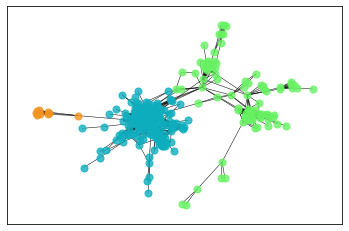

In [7]:
nx.draw_networkx_edges(G, pos, width=0.5, alpha=1)
for comp, color in zip(communities, ['#0FAEBF', '#68F263', '#F29422']):
    nx.draw_networkx_nodes(G, pos, nodelist=comp,
                           node_color=color,
                           node_size=50,
                           alpha=0.8)
plt.show()

# Question 2

### A

In [113]:
def get_kth_clique_communities(G, k):
    G_copy = G.copy()
    
    cliques = [(index, set(clique)) for index, clique in enumerate(nx.find_cliques(G))]
    clique_overlap_matrix = np.zeros((len(cliques),len(cliques)))
    np.fill_diagonal(clique_overlap_matrix, -1) # threshold for digonal is k (and not k-1)
    for (idx_1, clique_1), (idx_2, clique_2) in product(cliques, cliques):
        clique_overlap_matrix[idx_1,idx_2] += len(clique_1 & clique_2)
        
    clique_overlap_matrix = (clique_overlap_matrix >= (k-1)).astype(int)
    n_components, CC = connected_components(clique_overlap_matrix)
    communities = [set() for i in range(n_components)]
    
    for (index, clique), comp in zip(cliques, CC):
        communities[comp] = communities[comp].union(clique)
    
    return communities

In [118]:
# TEST
for i in range(50):
    p, k = (np.random.rand()+1)/2, np.random.randint(3, 5)
    G = nx.erdos_renyi_graph(20, p)
    our_communities = get_kth_clique_communities(G, k)
    nx_communities = k_clique_communities(G, k-1)
    nx_communities = [set(comp) for comp in nx_communities]
    assert(our_communities == nx_communities)
print('SUCCESS')

AssertionError: 

### B

In [101]:
slava_communities = pd.read_csv('communities.csv', sep=' ', header=None)
G = nx.empty_graph(slava_communities.max().max())
for index, (u, v) in slava_communities.iterrows():
    G.add_edge(u, v)
largest_CC_index = np.argmax([len(comp) for comp in nx.connected_components(G)])
largest_CC = [comp for comp in nx.connected_components(G)][largest_CC_index]
G = G.subgraph(largest_CC)

In [122]:
pos = nx.spring_layout(G)  # positions for all nodes
communities = get_kth_clique_communities(G, 4)
palette = sns.color_palette('crest', len(communities))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


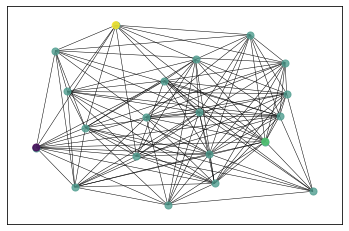

In [123]:
nx.draw_networkx_edges(G, pos, width=0.5, alpha=1)
for i, comp in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=comp,
                           node_color=palette[i],
                           node_size=50,
                           alpha=0.8)
plt.show()